In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [13]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        #self.x = df.iloc[:, 6:10].values
        self.x = df.iloc[:, 7:8].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[:, 13:14].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [14]:
dataset = CustomDataset("US06_80_1.csv")
print(dataset.x.shape)
print(dataset.x.dtype)
print(dataset.y.shape)
print(dataset.y.dtype)

(10693, 1)
float64
(10693, 1)
float64


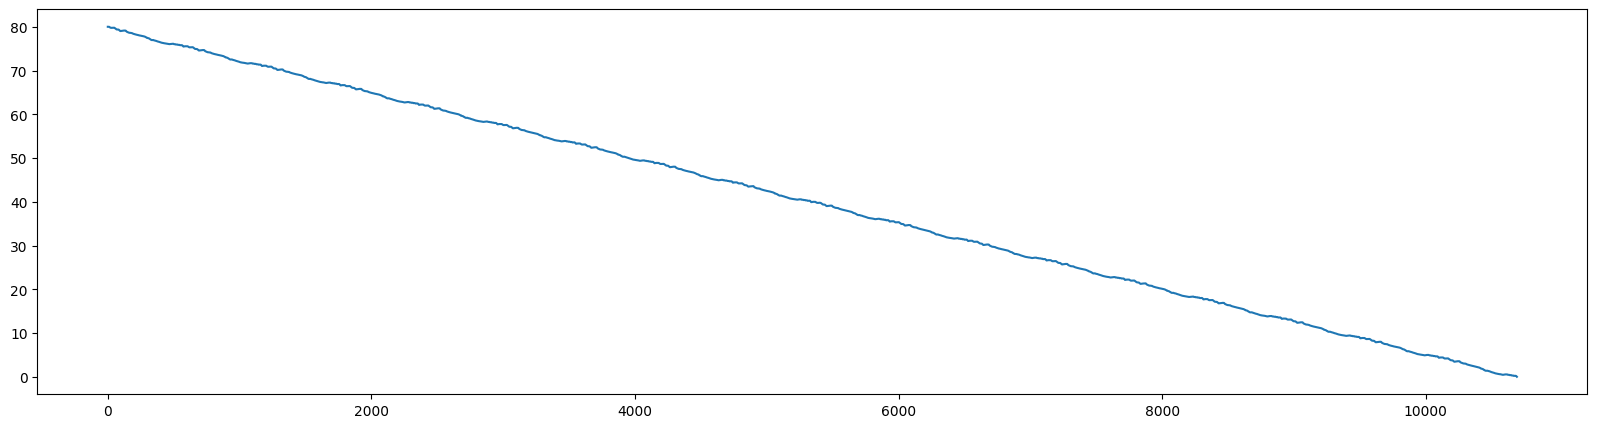

In [15]:
plt.figure(figsize=(20,5))
plt.plot(dataset.y)
plt.show()

In [16]:
dataset_size = len(dataset)
print(dataset_size)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])


print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

10693
Training Data Size : 8554
Validation Data Size : 1069
Testing Data Size : 1070


In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

In [18]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=10693):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

In [25]:
class TransAm(nn.Module):
    def __init__(self,feature_size=64,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(1,feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=8, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [26]:
num_epochs = 100
learning_rate = 0.01

# input_size = 5 
# hidden_size = 32
feature_size = 64
num_layers = 2
dropout = 0.1

# num_classes = 1

model = TransAm(feature_size, num_layers, dropout)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
writer = SummaryWriter()

def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0], data[1]
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [28]:
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0], data[1]
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [29]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(num_epochs):
    #print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    writer.add_scalar("Loss/train", train_epoch_loss, epoch)
    val_epoch_loss, val_epoch_accuracy = validate(
        model, validation_dataloader, validation_dataset, criterion
    )
    writer.add_scalar("Loss/val", val_epoch_loss, epoch)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if epoch % 10 == 0:
        print("Train Loss: %e, Train Acc: %.2f" %(train_epoch_loss, train_epoch_accuracy))
        print('Val Loss: %e, Val Acc: %.2f' %(val_epoch_loss, val_epoch_accuracy))
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

writer.flush()
writer.close()

Training


  0%|          | 0/133 [00:00<?, ?it/s]c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 133/133 [00:00<00:00, 211.08it/s]


Validating


  0%|          | 0/66 [00:00<?, ?it/s]c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 66/66 [00:00<00:00, 588.49it/s]


Train Loss: 7.089819e+02, Train Acc: 0.00
Val Loss: 5.480246e+02, Val Acc: 0.00
Training


100%|██████████| 133/133 [00:00<00:00, 214.82it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1042.13it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 228.86it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1081.94it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 228.69it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1064.51it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 216.95it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 956.58it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 179.34it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 709.70it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 142.23it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1081.99it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 153.98it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1187.06it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 154.44it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1205.26it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 148.60it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1137.96it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 145.35it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1157.89it/s]


Train Loss: 5.347392e+02, Train Acc: 0.00
Val Loss: 5.494097e+02, Val Acc: 0.00
Training


100%|██████████| 133/133 [00:00<00:00, 147.64it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1118.66it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 145.75it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1031.23it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 145.89it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1118.64it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 151.33it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 984.64it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 154.13it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1006.74it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 134.13it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 970.58it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 146.64it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1047.61it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 147.94it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1122.58it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 154.27it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1178.54it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 153.12it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1118.16it/s]


Train Loss: 5.344038e+02, Train Acc: 0.00
Val Loss: 5.506660e+02, Val Acc: 0.00
Training


100%|██████████| 133/133 [00:00<00:00, 152.01it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 834.71it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 150.99it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1081.97it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 146.57it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1039.17it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 154.08it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1081.33it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 152.82it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1064.52it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 152.43it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1031.27it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 152.08it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 721.16it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 155.46it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1157.94it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 149.23it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1100.01it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 141.12it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1023.13it/s]


Train Loss: 5.335504e+02, Train Acc: 0.00
Val Loss: 5.414046e+02, Val Acc: 0.00
Training


100%|██████████| 133/133 [00:00<00:00, 149.94it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1081.98it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 147.78it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 942.85it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 143.74it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 929.57it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 141.55it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1031.24it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 147.00it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1047.61it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 146.15it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1099.99it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 144.22it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 956.53it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 149.63it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1118.66it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 149.77it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1105.22it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 149.17it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1127.43it/s]


Train Loss: 5.341011e+02, Train Acc: 0.00
Val Loss: 5.588203e+02, Val Acc: 0.00
Training


100%|██████████| 133/133 [00:00<00:00, 150.30it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1118.67it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 142.49it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1114.69it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 145.16it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1047.60it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 147.93it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1118.55it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 140.44it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1047.60it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 146.42it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1047.59it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 143.08it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1118.62it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 146.31it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1100.01it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 141.96it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1099.99it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 145.52it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1116.51it/s]


Train Loss: 5.340391e+02, Train Acc: 0.00
Val Loss: 5.453061e+02, Val Acc: 0.00
Training


100%|██████████| 133/133 [00:00<00:00, 143.47it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1064.49it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 144.93it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1060.91it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 142.77it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 996.25it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 144.28it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1140.68it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 145.63it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 846.12it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 149.41it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 672.99it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 148.22it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1118.62it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 146.74it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1047.63it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 146.07it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1222.21it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 139.42it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1081.99it/s]


Train Loss: 5.338619e+02, Train Acc: 0.00
Val Loss: 5.455439e+02, Val Acc: 0.00
Training


100%|██████████| 133/133 [00:00<00:00, 143.89it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1081.99it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 136.95it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1100.01it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 139.48it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1081.98it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 139.98it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 985.05it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 142.62it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 817.03it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 143.44it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1118.25it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 136.78it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1132.67it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 133.32it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1100.00it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 140.01it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1137.91it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 143.28it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1109.01it/s]


Train Loss: 5.338196e+02, Train Acc: 0.00
Val Loss: 5.451431e+02, Val Acc: 0.00
Training


100%|██████████| 133/133 [00:00<00:00, 139.81it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 706.24it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 139.49it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 687.28it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 139.27it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1064.49it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 140.13it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1118.66it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 139.74it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1059.46it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 137.20it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1141.59it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 141.35it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1153.49it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 140.98it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1107.10it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 138.31it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1064.52it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 136.84it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1147.60it/s]


Train Loss: 5.339989e+02, Train Acc: 0.00
Val Loss: 5.446030e+02, Val Acc: 0.00
Training


100%|██████████| 133/133 [00:00<00:00, 135.31it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1099.97it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 133.65it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1070.84it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 136.61it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1072.85it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 136.29it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1148.76it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 136.54it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 785.71it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 135.71it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1099.97it/s]


Training


100%|██████████| 133/133 [00:01<00:00, 132.02it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1123.08it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 133.35it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1100.01it/s]


Training


100%|██████████| 133/133 [00:00<00:00, 134.82it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1099.99it/s]


Training


100%|██████████| 133/133 [00:01<00:00, 130.66it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1099.98it/s]


Train Loss: 5.348789e+02, Train Acc: 0.00
Val Loss: 5.470224e+02, Val Acc: 0.00
Training


100%|██████████| 133/133 [00:01<00:00, 132.87it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 835.44it/s]


Training


100%|██████████| 133/133 [00:01<00:00, 130.10it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 970.54it/s]


Training


100%|██████████| 133/133 [00:01<00:00, 128.58it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1178.08it/s]


Training


100%|██████████| 133/133 [00:01<00:00, 126.41it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1137.93it/s]


Training


100%|██████████| 133/133 [00:01<00:00, 131.12it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1081.96it/s]


Training


100%|██████████| 133/133 [00:01<00:00, 124.19it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1064.51it/s]


Training


100%|██████████| 133/133 [00:01<00:00, 129.91it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1100.00it/s]


Training


100%|██████████| 133/133 [00:01<00:00, 124.68it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1000.01it/s]


Training


100%|██████████| 133/133 [00:01<00:00, 126.00it/s]


Validating


100%|██████████| 66/66 [00:00<00:00, 1081.96it/s]

Training time: 1.644 minutes


[42.598263 42.598255 42.59826  ... 42.598255 42.59826  42.598255]


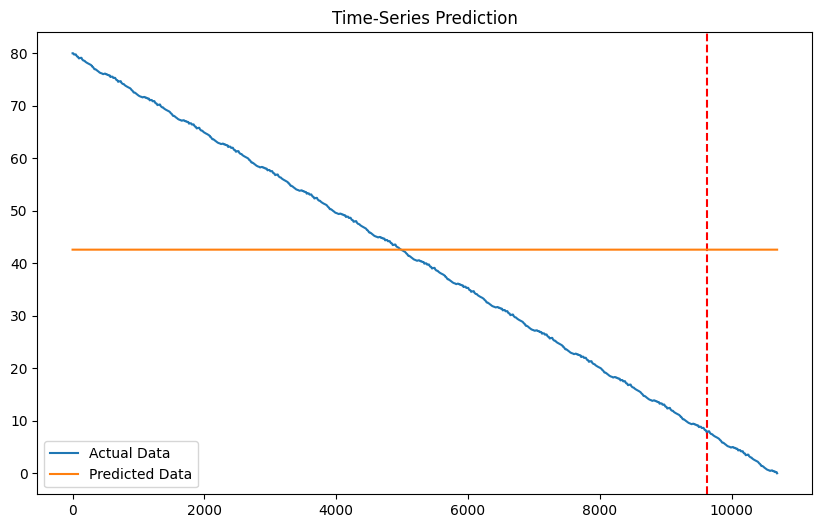

In [30]:
df_x_ss = dataset.x
df_y_ms = dataset.y

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
predicted = predicted.squeeze()
print(predicted)
label_y = df_y_ms.data.numpy()


plt.figure(figsize=(10,6)) 
plt.axvline(x=dataset_size-test_size, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 

plt.title('Time-Series Prediction')
plt.legend()
plt.show()

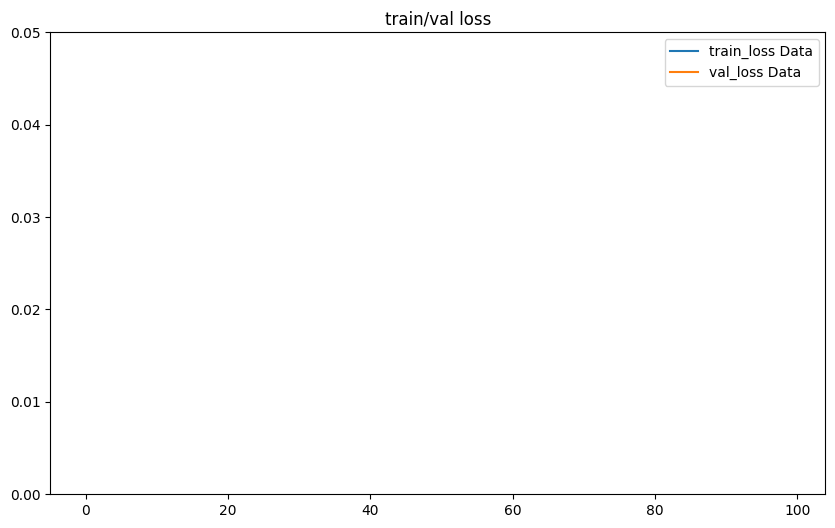

In [31]:
plt.figure(figsize=(10,6))

plt.plot(train_loss, label='train_loss Data') 
plt.plot(val_loss, label='val_loss Data') 
plt.ylim([0, 0.05])
plt.title('train/val loss')

plt.legend()
plt.show()
